# Reto | Generación de un modelo inteligente de clasificación con redes neuronales profundas para la detección de amenazas aéreas

**Objetivos**:
El objetivo de este reto es poner en práctica los contenidos revisados durante el módulo realizando los siguientes pasos:

- Preparar una base de datos y generar los conjuntos de entrenamiento y prueba.
- Diseñar un modelo utilizando una red neuronal convolucional desde cero y determinar sus hiperparámetros.
- Diseñar un modelo utilizando una red neuronal convolucional utilizando un modelo pre-entrenado.
- Generar un modelo utilizando la herramienta Teachable Machine.
- Validar, evaluar y comparar los tres diferentes modelos generados y seleccionar el mejor considerando la exactitud como indicador de desempeño.
- Exportar los modelos generados para poder utilizarlos dentro de Colab o algún otro sitio.

## 1. Preprocesamiento de la base de datos

In [1]:
# Montando Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import pathlib
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
# Eliminando cualquiero archivo que no sea JPG, JPEG, PNG
!find /content/drive/MyDrive/Reto/datos/objetos -type f ! -name "*.jpg" ! -name "*.jpeg" ! -name "*.png" -delete


In [4]:
# Directorio base
dir_base = '/content/drive/MyDrive/Reto/datos/objetos'
dir_base = pathlib.Path(dir_base)
conteo_img = len(list(dir_base.glob('*/*')))
print('El total de imágenes es de:',conteo_img)


El total de imágenes es de: 8218


In [ ]:
# Correr si hay error al momento de entrenar el primer modelo
# for img_path in dir_base.rglob('*.[jp][pn]g'):
#     try:
#         img = tf.io.read_file(str(img_path))
#         img = tf.image.decode_image(img,channels=3)
#     except:
#         print('Error al decodificar:',img_path)
#         os.remove(img_path)

## 2. Generación de conjuntos de entrenamiento, prueba y aumentación de datos

In [5]:
# Tamaño de las imágenes y lote
alto_img = 224
ancho_img = 224
tam_lote = 32

Para la creación de los conjuntos de entrenamiento y prueba se usará la función:

```
image_dataset_from_directory
```



In [6]:
# Definición del conjunto de entrenamiento
conj_entrenamiento = tf.keras.preprocessing.image_dataset_from_directory(
    dir_base,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(alto_img,ancho_img),
    batch_size=tam_lote
)

# Definición del conjunto de prueba
conj_prueba = tf.keras.preprocessing.image_dataset_from_directory(
    dir_base,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(alto_img,ancho_img),
    batch_size=tam_lote
)

Found 8218 files belonging to 6 classes.
Using 6575 files for training.
Found 8218 files belonging to 6 classes.
Using 1643 files for validation.


In [7]:
# Prefetch y Cache
conj_entrenamiento = conj_entrenamiento.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
conj_prueba = conj_prueba.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


## 3. Diseña una arquitectura de una red neuronal convolucional profunda desde cero para resolver el problema de clasificación


In [8]:
from tensorflow.keras import regularizers
# Definición del primer modelo
redConv = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(alto_img,ancho_img,3)),
    tf.keras.layers.Rescaling(1/255),

    # Data Augmentation
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomContrast(0.15),

    # Convoluciones
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),


    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.35),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(256,activation='relu',
                          kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128,activation='relu',
                          kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(6,activation='softmax')
])
redConv.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 111, 111, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 111, 111, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 55, 55, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 55, 55, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 489,798 (1.87 MB)

 Trainable params: 488,838 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [9]:
# Compilación del modelo
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

opt = Adam(learning_rate=5e-4)
redConv.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# Reducir learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=4,
    min_lr=1e-6,
    verbose=1
)
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## 4. Diseña una arquitectura de una red neuronal convolucional profunda que utilice como base un modelo pre-entrenado para resolver el problema de clasificación

Al usar un modelo pre-entrenado se usará:

```
MobileNetV2
```
Así mismo, para evitar que los ecosistemas tengan problemas, se utilizarán pesos predefinidos.



In [13]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.3),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

#### 4.1 Modelo MobileNetV2
Al usar un modelo pre-entrenado se usará:

```
MobileNetV2
```
Así mismo, para evitar que los ecosistemas tengan problemas, se utilizarán pesos predefinidos.


In [45]:

# Configurar modelo pre-entrenado
forma_img = (224,224,3)
modelo_base = tf.keras.applications.MobileNetV2(
    input_shape = forma_img,
    include_top = False,
    weights='imagenet'
)
modelo_base.trainable = False

Es importante normalizar los datos de entrada en la base convolucional.

In [46]:
from tensorflow.keras import regularizers
# Modelo completo
inputs = tf.keras.Input(shape=forma_img)
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = modelo_base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
modelo_pre = tf.keras.Model(inputs, outputs)
modelo_pre.summary()

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 4.2 Modelo Preentreado EfficientNetB0

In [11]:
modelo_base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

modelo_base.trainable = False

In [14]:
# Modelo Completo
inputs = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = modelo_base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(6,activation='softmax')(x)
modelo_completo = tf.keras.Model(inputs,outputs)
modelo_completo.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Compilación del modelo
opt = Adam(learning_rate=1e-4)
modelo_completo.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)
# Reducir Learning Rate
lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

## 5. Modelo con Teachable Machine
Para la generación del modelo en Teachable Machine se declararán 6 clases:
1. Misil
2. Jet
3. Helicóptero
4. Dron
5. Cohete
6. Avión

Para la creación del modelo se eligirán las primeras 200 imágenes de cada clase.

Los hiperparámetros serán los siguientes:

- Épocas: 50
- Tamaño del lote: 32
- Tasa de aprendizaje : 0.001

## 6. Entrena y ajusta las arquitecturas diseñadas

### 6.1 Primer Modelo

In [10]:
# Entrenamiento del modelo
evolucion = redConv.fit(
    conj_entrenamiento,
    validation_data = conj_prueba,
    epochs = 50,
    callbacks = [early_stopping,reduce_lr]
 )

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2050s 2s/step - accuracy: 0.2172 - loss: 1.9381 - val_accuracy: 0.1601 - val_loss: 2.1115 - learning_rate: 5.0000e-04
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step - accuracy: 0.2833 - loss: 1.7569 - val_accuracy: 0.1582 - val_loss: 1.9552 - learning_rate: 5.0000e-04
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - accuracy: 0.3042 - loss: 1.7237 - val_accuracy: 0.3001 - val_loss: 1.6956 - learning_rate: 5.0000e-04
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 33s 162ms/step - accuracy: 0.3136 - loss: 1.7011 - val_accuracy: 0.3031 - val_loss: 1.7219 - learning_rate: 5.0000e-04
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 33s 159ms/step - accuracy: 0.3168 - loss: 1.6879 - val_accuracy: 0.3402 - val_loss: 1.6590 - learning_rate: 5.0000e-04
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - accuracy: 0.3513 - loss: 1.6576 - val_accuracy: 0.3506 - val_loss: 1.6402 - learning_rate: 5.0000e-04
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 32s 157

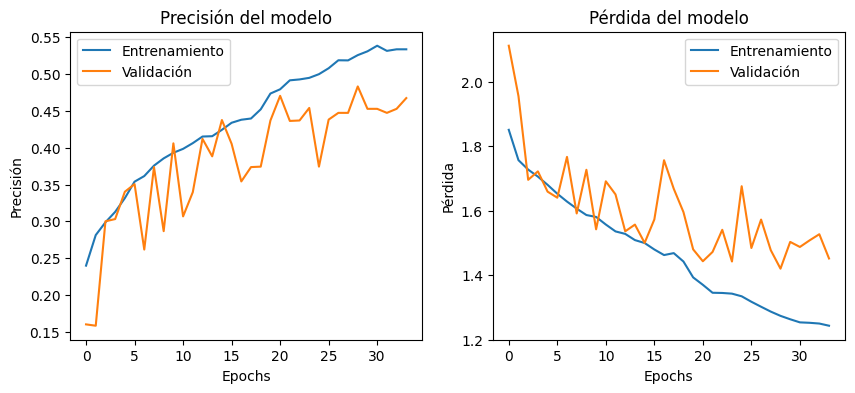

In [12]:
# Gráfico de la evolución de entrenamiento y pérdida
# Historial de entrenamiento
hist = evolucion.history
plt.figure(figsize=(10,4))

# Presición del modelo
plt.subplot(1,2,1)
plt.plot(hist['accuracy'],label='Entrenamiento')
plt.plot(hist['val_accuracy'],label='Validación')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.title('Precisión del modelo')
plt.legend()

# Pérdida del modelo
plt.subplot(1,2,2)
plt.plot(hist['loss'],label='Entrenamiento')
plt.plot(hist['val_loss'],label='Validación')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.title('Pérdida del modelo')
plt.legend()

plt.show()

### 6.2 Modelo Preentrenado MobileNetV2

In [47]:
# Compilar modelo final
modelo_pre.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

# Callbacks
lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

Se entrenará el clasificador con el modelo base congelado, posteriormente, se hará fine-tuning, descongelando las últimas capas de MobileNetV2 para obtener mejores resultados.

In [48]:

# Entrenamiento
historial_1 = modelo_pre.fit(
    conj_entrenamiento,
    epochs=10,
    validation_data = conj_prueba,
    callbacks = [early_stopping,reduce_lr]
)

Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.1715 - loss: 2.1776 - val_accuracy: 0.1716 - val_loss: 1.8898 - learning_rate: 1.0000e-05
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.2229 - loss: 1.9108 - val_accuracy: 0.2355 - val_loss: 1.7880 - learning_rate: 1.0000e-05
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.2535 - loss: 1.8111 - val_accuracy: 0.2928 - val_loss: 1.7174 - learning_rate: 1.0000e-05
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.2931 - loss: 1.7381 - val_accuracy: 0.3366 - val_loss: 1.6614 - learning_rate: 1.0000e-05
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.3159 - loss: 1.6786 - val_accuracy: 0.3731 - val_loss: 1.6120 - learning_rate: 1.0000e-05
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.3637 - loss: 1.6140 - val_accuracy: 0.3865 - val_loss: 1.5761 - learning_rate: 1.0000e-05
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/ste

In [49]:
# Fine-Tuning
modelo_base.trainable = True
# Se entrenarán las últimas 30 capas
for layer in modelo_base.layers[:-30]:
    layer.trainable = False

# Compilación del modelo
modelo_pre.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [52]:
# Entrenamiento
historia_2 = modelo_pre.fit(
    conj_entrenamiento,
    epochs=20,
    validation_data = conj_prueba,
    callbacks = [early_stopping,reduce_lr]
)

Epoch 1/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 34s 102ms/step - accuracy: 0.3673 - loss: 1.5775 - val_accuracy: 0.4839 - val_loss: 1.3447 - learning_rate: 1.0000e-05
Epoch 2/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.4363 - loss: 1.4451 - val_accuracy: 0.5210 - val_loss: 1.2639 - learning_rate: 1.0000e-05
Epoch 3/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.4766 - loss: 1.3486 - val_accuracy: 0.5386 - val_loss: 1.2131 - learning_rate: 1.0000e-05
Epoch 4/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.5042 - loss: 1.2963 - val_accuracy: 0.5593 - val_loss: 1.1660 - learning_rate: 1.0000e-05
Epoch 5/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.5181 - loss: 1.2502 - val_accuracy: 0.5733 - val_loss: 1.1411 - learning_rate: 1.0000e-05
Epoch 6/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.5393 - loss: 1.2109 - val_accuracy: 0.5873 - val_loss: 1.1093 - learning_rate: 1.0000e-05
Epoch 7/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/st

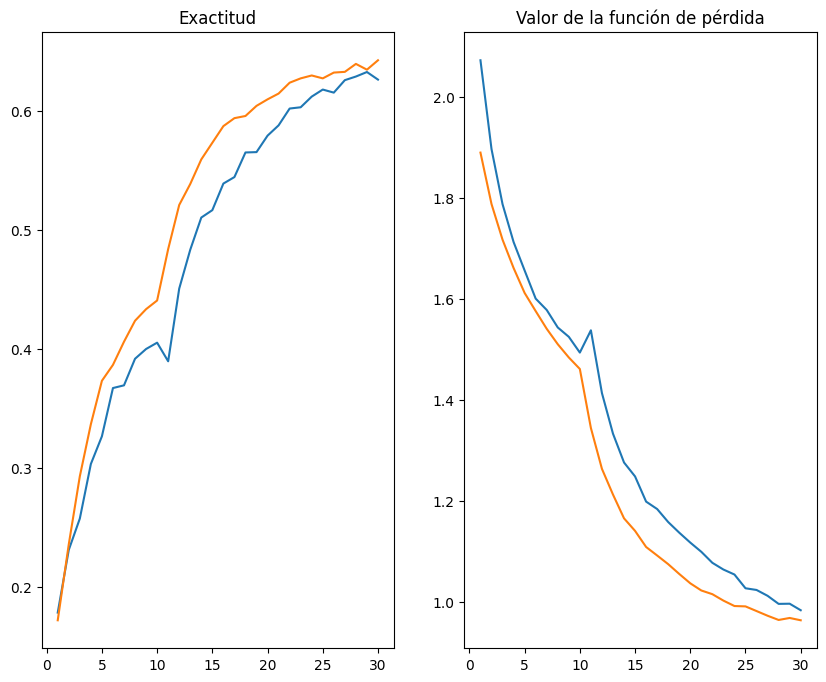

In [53]:
# Combinando historiales
acc = historial_1.history['accuracy'] + historia_2.history['accuracy']
val_acc = historial_1.history['val_accuracy'] + historia_2.history['val_accuracy']

loss = historial_1.history['loss'] + historia_2.history['loss']
val_loss = historial_1.history['val_loss'] + historia_2.history['val_loss']

epochs = range(1, len(acc) + 1)

# Gráfica de la evolución de entrenamiento y pérdida
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(epochs,acc,label='Exactitud Entrenamiento')
plt.plot(epochs,val_acc,label='Exactitud Validación')
plt.title('Exactitud')

plt.subplot(1,2,2)
plt.plot(epochs,loss,label='Perdida Entrenamiento')
plt.plot(epochs,val_loss,label='Perdida Validación')
plt.title('Valor de la función de pérdida')

plt.show()

### 6.3 Modelo Preentrenado EfficientNetB0

In [16]:
# Entrenamiento
historial_1 = modelo_completo.fit(
    conj_entrenamiento,
    validation_data=conj_prueba,
    epochs=10,
    callbacks=[early_stopping,lr]
)

Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 1366s 1s/step - accuracy: 0.2454 - loss: 1.7799 - val_accuracy: 0.3987 - val_loss: 1.5273 - learning_rate: 1.0000e-04
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.3822 - loss: 1.5492 - val_accuracy: 0.4900 - val_loss: 1.3879 - learning_rate: 1.0000e-04
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.4372 - loss: 1.4416 - val_accuracy: 0.5222 - val_loss: 1.3029 - learning_rate: 1.0000e-04
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.4891 - loss: 1.3643 - val_accuracy: 0.5447 - val_loss: 1.2487 - learning_rate: 1.0000e-04
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.5147 - loss: 1.3056 - val_accuracy: 0.5709 - val_loss: 1.2092 - learning_rate: 1.0000e-04
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.5208 - loss: 1.2721 - val_accuracy: 0.5819 - val_loss: 1.1814 - learning_rate: 1.0000e-04
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/ste

In [17]:
# Fine- Tuning
modelo_base.trainable = True
for layer in modelo_base.layers[:-30]:
    layer.trainable = False

# Compilación del modelo
modelo_completo.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

# Entrenamiento
historia_2 = modelo_completo.fit(
    conj_entrenamiento,
    validation_data=conj_prueba,
    epochs=20,
    callbacks=[early_stopping,lr]
)

Epoch 1/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 126ms/step - accuracy: 0.4826 - loss: 1.3466 - val_accuracy: 0.6074 - val_loss: 1.1196 - learning_rate: 1.0000e-05
Epoch 2/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - accuracy: 0.5098 - loss: 1.2760 - val_accuracy: 0.6032 - val_loss: 1.1228 - learning_rate: 1.0000e-05
Epoch 3/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - accuracy: 0.5423 - loss: 1.2384 - val_accuracy: 0.6086 - val_loss: 1.1014 - learning_rate: 1.0000e-05
Epoch 4/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - accuracy: 0.5458 - loss: 1.2190 - val_accuracy: 0.6129 - val_loss: 1.0820 - learning_rate: 1.0000e-05
Epoch 5/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - accuracy: 0.5625 - loss: 1.1546 - val_accuracy: 0.6178 - val_loss: 1.0654 - learning_rate: 1.0000e-05
Epoch 6/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - accuracy: 0.5773 - loss: 1.1533 - val_accuracy: 0.6220 - val_loss: 1.0480 - learning_rate: 1.0000e-05
Epoch 7/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 23s 11

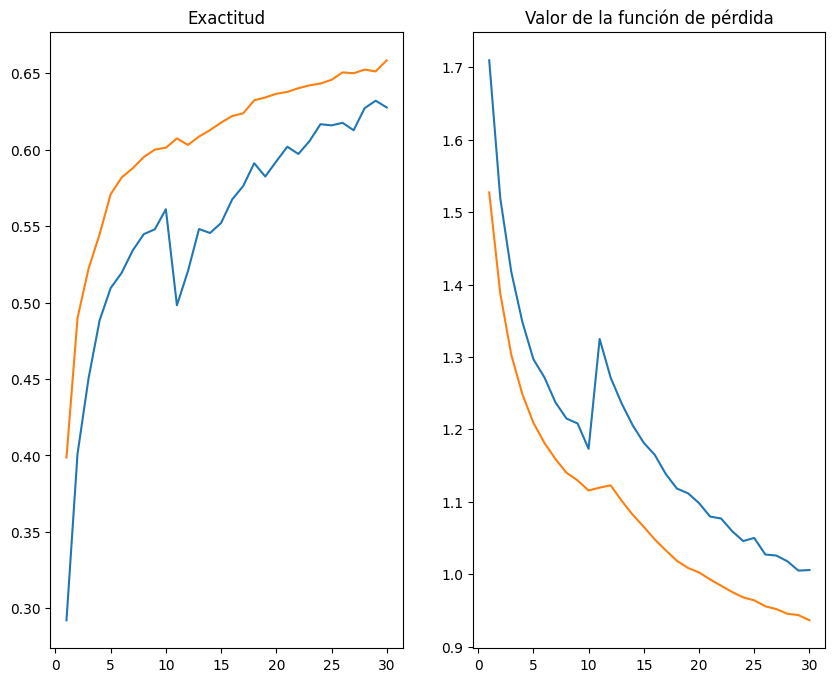

In [18]:
# Combinando historiales
acc = historial_1.history['accuracy'] + historia_2.history['accuracy']
val_acc = historial_1.history['val_accuracy'] + historia_2.history['val_accuracy']

loss = historial_1.history['loss'] + historia_2.history['loss']
val_loss = historial_1.history['val_loss'] + historia_2.history['val_loss']

epochs = range(1, len(acc) + 1)

# Gráfica de la evolución de entrenamiento y pérdida
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(epochs,acc,label='Exactitud Entrenamiento')
plt.plot(epochs,val_acc,label='Exactitud Validación')
plt.title('Exactitud')

plt.subplot(1,2,2)
plt.plot(epochs,loss,label='Perdida Entrenamiento')
plt.plot(epochs,val_loss,label='Perdida Validación')
plt.title('Valor de la función de pérdida')

plt.show()
plt.show()

### 6.4 Modelo de Teachable Machine

In [29]:
from keras import layers, Sequential
from PIL import Image, ImageOps
import numpy as np

# Definiendo ruta
ruta_modelo = '/content/drive/MyDrive/Reto/model.savedmodel1'

# Cargando modelo
modelo_tm = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224,224,3)),
    tf.keras.layers.TFSMLayer(ruta_modelo,call_endpoint='serving_default')
])

# Compilando el modelo
modelo_tm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


## 7. Exportación de Modelos

### 7.1 Primer Modelo

In [13]:
# Guardar modelo
redConv.save('/content/drive/MyDrive/Reto/modelo_redConv.keras')


In [ ]:
# Cargar modelo
modelo_redConv = tf.keras.models.load_model(
    '/content/drive/MyDrive/Reto/modelo_redConv.keras')

### 7.2 Modelo pre-entrenado MobileNetV2

In [54]:
# Guardar modelo
modelo_pre.save('/content/drive/MyDrive/Reto/modelo_pre.keras')

In [ ]:

# Cargar modelo
modelo_prentrenado = tf.keras.models.load_model(
    '/content/drive/MyDrive/Reto/modelo_pre.keras')

### 7.3 Modelo preentrenado EfficientNetB0

In [19]:
# Guardar modelo
modelo_completo.save('/content/drive/MyDrive/Reto/modelo_completoB0.keras')


In [20]:
# Cargar modelo
modelo_prentrenado_B0 = tf.keras.models.load_model(
    '/content/drive/MyDrive/Reto/modelo_completoB0.keras')

### 7.4 Modelo de Teachable Machine

In [30]:
# Cargar modelo
modelo_tm.save('/content/drive/MyDrive/Reto/modelo_TM.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 320 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Cargar modelo
modelo_TM = tf.keras.models.load_model(
    '/content/drive/MyDrive/Reto/modelo_TM.keras')

## 8. Comparativa de los tres modelos generados en el problema de clasificación

### 8.1 Evaluación del Primer Modelo

In [14]:
# Pérdida y Exactitud
loss_redConv, acc_redConv = modelo_redConv.evaluate(conj_prueba)
print(f' Pérdida del modelo: {loss_redConv:.4f}')
print(f' Exactitud del modelo: {acc_redConv:.4f}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4521 - loss: 1.4506
 Pérdida del modelo: 1.4201
 Exactitud del modelo: 0.4833


### 8. 2 Evaluación del Modelo Preentrenado MobileNetV2

In [55]:
loss_pre, acc_pre = modelo_prentrenado.evaluate(conj_prueba)
print(f' Pérdida del modelo pre-entrenado: {loss_pre:.4f}')
print(f' Exactitud del modelo pre-entrenado: {acc_pre:.4f}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.6189 - loss: 1.0213
 Pérdida del modelo pre-entrenado: 0.9642
 Exactitud del modelo pre-entrenado: 0.6427


### 8. 3 Evaluación del Modelo Preentrenado EfficientNetB0

In [21]:
loss_eff, acc_eff = modelo_prentrenado_B0.evaluate(conj_prueba)
print(f' Pérdida del modelo pre-entrenado: {loss_eff:.4f}')
print(f' Exactitud del modelo pre-entrenado: {acc_eff:.4f}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.6382 - loss: 0.9799
 Pérdida del modelo pre-entrenado: 0.9365
 Exactitud del modelo pre-entrenado: 0.6586


### 8.4 Evaluación del modelo de Teachable Machine

In [31]:
# Pérdida y Exactitud
loss_tm, acc_tm = modelo_tm.evaluate(conj_prueba)
print(f' Pérdida del modelo: {loss_tm:.4f}')
print(f' Exactitud del modelo: {acc_tm:.4f}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - accuracy: 0.1757 - loss: 7.4335
 Pérdida del modelo: 7.3526
 Exactitud del modelo: 0.1808


### 7.4 Comparación de los tres modelos

#### 7.4.1 Comparación de exactitudes

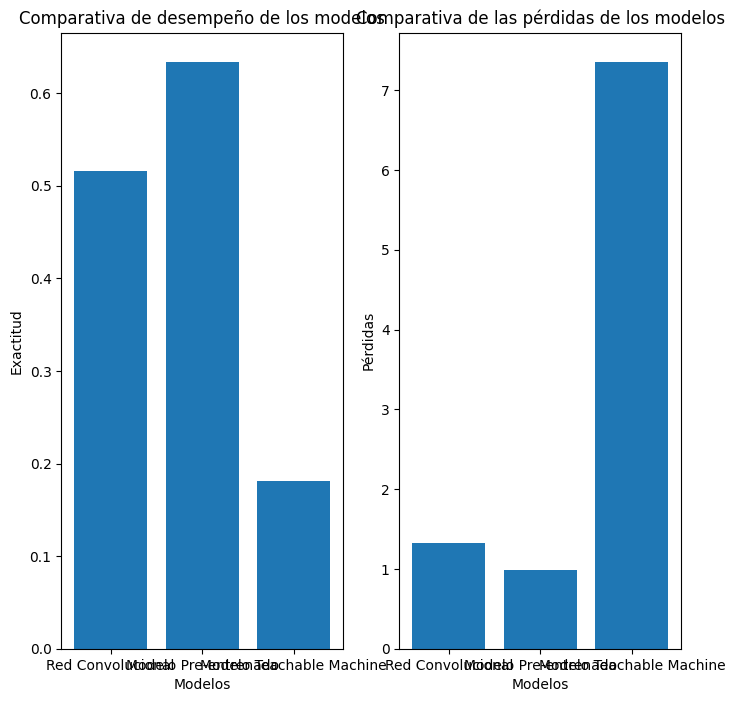

In [ ]:
exactitudes = [acc_redConv,acc_pre,acc_tm]
modelos = ['Red Convolucional','Modelo Pre-entrenado','Modelo Teachable Machine']
plt.figure(figsize=(15,15))
plt.bar(modelos,exactitudes)
plt.xlabel('Modelos')
plt.ylabel('Exactitud')
plt.title('Comparativa de desempeño de los modelos')

#### 7.4.2 Comparación de pérdidas

In [ ]:
perdidas = [loss_redConv,loss_pre,loss_tm]
modelos = ['Red Convolucional','Modelo Pre-entrenado','Modelo Teachable Machine']
plt.figure(figsize=(15,15))
plt.bar(modelos,perdidas)
plt.xlabel('Modelos')
plt.ylabel('Pérdidas')
plt.title('Comparativa de las pérdidas de los modelos')
plt.show()

## 8. Selección del mejor modelo